In [94]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, normalized_mutual_info_score, adjusted_rand_score, precision_score, recall_score, f1_score


In [95]:
# data augmentation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download trainset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# download testset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


# cifar-10 class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [96]:
# valset definition
torch.manual_seed(43)
val_size = 5000
train_size = len(trainset) - val_size

# train val split
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print(len(train_ds), len(val_ds))


# define batch_size
batch_size = 4

# define train_loader
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# define val_loader
valloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# define test_loader
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

45000 5000


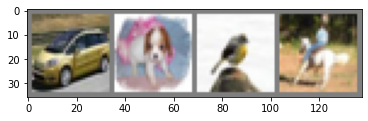

  car   dog  bird horse


In [97]:
# random visualize
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# random get train data
dataiter = iter(trainloader)
images, labels = dataiter.next()

# visualize images
imshow(torchvision.utils.make_grid(images))
# show class information
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## MLP-based Approach

In [65]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, num_class)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(-1,32*32*3)
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [66]:
# get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [67]:
# define number of classes
NUM_CLASS = 10
# define input size
INPUT_DIM = 32*32*3
# define hidden dimension
HIDDEN_DIM = 256
# load cnn model 
mlp = MLP(INPUT_DIM, HIDDEN_DIM, NUM_CLASS).to(device)
# define loss function
criterion = nn.CrossEntropyLoss()
# define optimizer
optimizer = optim.Adam(mlp.parameters(), lr=0.0001)
# define log interval
log_freq = 500
# define validate interval
val_freq = 1
# define max_epoch
MAX_EPOCHS = 5
# define model save path
PATH = './mlp_net.pth'

In [68]:
for epoch in range(MAX_EPOCHS): 
    # initialize loss
    running_loss = 0.0
    best_acc = -100
    
    for i, data in enumerate(trainloader):
        # get data from loader and feed to correspondent device
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # set gradient to zero
        optimizer.zero_grad()

        # forward & backward
        outputs = mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save loss
        running_loss += loss.item()
    
        
        # print loss
        if (i+1) % log_freq == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / log_freq))
            running_loss = 0.0
       
    print('Start Validation')
    if (epoch+1) % val_freq == 0:
            correct = 0
            total = 0
            
            # no gradient update during validation
            with torch.no_grad():
                
                for i, data in enumerate(valloader):
                    # get data from loader and feed to correspondent device
                    images, labels = data
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # inference
                    outputs = mlp(images)
                    
                    # get prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                # calculate accuracy
                acc = correct / total
                print('Accuracy of the network on the val dataset: %d %%' % (
                100 * acc))
                
                # save the best model
                if acc > best_acc:
                    best_acc = acc
                    torch.save(mlp.state_dict(), PATH)
                    print('Best Model Saved with best score ', best_acc)

                
print('Finished Training')

[1,   500] loss: 2.158
[1,  1000] loss: 2.070
[1,  1500] loss: 2.021
[1,  2000] loss: 2.011
[1,  2500] loss: 2.005
[1,  3000] loss: 1.992
[1,  3500] loss: 1.991
[1,  4000] loss: 1.978
[1,  4500] loss: 1.963
[1,  5000] loss: 1.965
[1,  5500] loss: 1.964
[1,  6000] loss: 1.964
[1,  6500] loss: 1.957
[1,  7000] loss: 1.956
[1,  7500] loss: 1.963
[1,  8000] loss: 1.949
[1,  8500] loss: 1.953
[1,  9000] loss: 1.944
[1,  9500] loss: 1.939
[1, 10000] loss: 1.927
[1, 10500] loss: 1.931
[1, 11000] loss: 1.947
Start Validation
Accuracy of the network on the val dataset: 41 %
Best Model Saved with best score  0.4182
[2,   500] loss: 1.925
[2,  1000] loss: 1.916
[2,  1500] loss: 1.927
[2,  2000] loss: 1.908
[2,  2500] loss: 1.915
[2,  3000] loss: 1.908
[2,  3500] loss: 1.922
[2,  4000] loss: 1.910
[2,  4500] loss: 1.915
[2,  5000] loss: 1.916
[2,  5500] loss: 1.915
[2,  6000] loss: 1.918
[2,  6500] loss: 1.911
[2,  7000] loss: 1.910
[2,  7500] loss: 1.899
[2,  8000] loss: 1.911
[2,  8500] loss: 1.

### evaluation on testset

##### Prepare Model #####
##### Compute Metrics on Test Data #####


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 352.19it/s]


Accuracy on test data: 0.4823
Precision on test data: 0.3792
Recall on test data: 0.3803
F1-score on test data: 0.3700
NMI score on test data: 0.8627
ARI score on test data: 0.3767
Confusion matrix on test data
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[589.  28.  39.  18.  21.  21.  28.  54. 141.  61.]
 [ 43. 490.  22.  30.  13.  26.  31.  26.  90. 229.]
 [103.  16. 338.  91. 132. 103.  95.  70.  33.  19.]
 [ 46.  18.  90. 327.  30. 253.  97.  52.  31.  56.]
 [ 63.  10. 152.  68. 381.  63. 126.  93.  22.  22.]
 [ 27.   4.  85. 191.  57. 437.  70.  64.  34.  31.]
 [ 15.  13.  83.  88.  99.  97. 536.  28.  14.  27.]
 [ 48.  10.  55.  53.  89. 111.  30. 517.  27.  60.]
 [130.  58.  11.  23.  13.  35.   7.  19. 619.  85.]
 [ 48. 123.  14.  36.   6.  24.  36.  50.  74. 589.]]


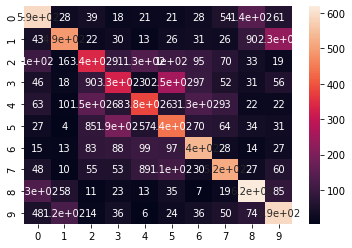

In [98]:
# initialize test dict
test_dict = dict()
for i in range(len(testset.classes)):
    test_dict[i] = dict()
    for cls in testset.classes:
        test_dict[i][cls] = 0

# initialize map
class_map = dict()
for i, cls in enumerate(testset.classes):
    class_map[i] = cls

# prepare model
print('##### Prepare Model #####')
model = MLP(INPUT_DIM, HIDDEN_DIM, NUM_CLASS).to(device)
# load checkpoint
model.load_state_dict(torch.load('mlp_net.pth'))

# compute accuracy
print('##### Compute Metrics on Test Data #####')
test_acc = 0.0
test_auc = 0.0
test_confusion_mat = 0.0
test_nmi = 0.0
test_ari = 0.0
test_prec = 0.0
test_recall = 0.0
test_f1 = 0.0
model.eval()
for (imgs, target) in tqdm(testloader):
    imgs, target = imgs.cuda(), target.cuda()
    with torch.no_grad():
        pred = model(imgs)
        prob = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1)

        target_np, prob_np, pred_np = target.data.cpu().numpy(), prob.data.cpu().numpy(), pred.data.cpu().numpy()

        # update test dict
        for i in range(target_np.shape[0]):
            cls = class_map[target_np[i]]
            test_dict[pred_np[i]][cls] += 1

        # update metrics
        acc = accuracy_score(target_np, pred_np)
        confusion_mat = confusion_matrix(target_np, pred_np, labels=np.arange(0, len(testloader.dataset.classes)))
        nmi = normalized_mutual_info_score(target_np, pred_np)
        ari = adjusted_rand_score(target_np, pred_np)
        prec = precision_score(target_np, pred_np, average='macro')
        recall = recall_score(target_np, pred_np, average='macro')
        f1 = f1_score(target_np, pred_np, average='macro')
    test_acc += acc
    test_confusion_mat += confusion_mat
    test_nmi += nmi
    test_ari += ari
    test_prec += prec
    test_recall += recall
    test_f1 += f1

test_acc /= len(testloader)
test_nmi /= len(testloader)
test_ari /= len(testloader)
test_prec /= len(testloader)
test_recall /= len(testloader)
test_f1 /= len(testloader)


print(f'Accuracy on test data: {test_acc:.4f}')
print(f'Precision on test data: {test_prec:.4f}')
print(f'Recall on test data: {test_recall:.4f}')
print(f'F1-score on test data: {test_f1:.4f}')
print(f'NMI score on test data: {test_nmi:.4f}')
print(f'ARI score on test data: {test_ari:.4f}')
print('Confusion matrix on test data')
print(f'{testset.classes}')
print(test_confusion_mat)

# plot heatmap
sns_plot = sns.heatmap(test_confusion_mat, annot=True)
sns_plot.figure.savefig('heatmap.png')

## CNN-based Approach

In [90]:
# get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [91]:
# define number of classes
NUM_CLASS = 10
# load cnn model 
net = models.vgg16(NUM_CLASS, False).to(device)
# define loss function
criterion = nn.CrossEntropyLoss()
# define optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
# define log interval
log_freq = 500
# define validate interval
val_freq = 1
# define max_epoch
MAX_EPOCHS = 5
# define model save path
PATH = './vgg_net.pth'

In [ ]:
for epoch in range(MAX_EPOCHS): 
    # initialize loss
    running_loss = 0.0
    best_acc = -100
    
    for i, data in enumerate(trainloader):
        # get data from loader and feed to correspondent device
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # set gradient to zero
        optimizer.zero_grad()

        # forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save loss
        running_loss += loss.item()
    
        
        # print loss
        if (i+1) % log_freq == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / log_freq))
            running_loss = 0.0
       
    print('Start Validation')
    if (epoch+1) % val_freq == 0:
            correct = 0
            total = 0
            
            # no gradient update during validation
            with torch.no_grad():
                
                for i, data in enumerate(valloader):
                    # get data from loader and feed to correspondent device
                    images, labels = data
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # inference
                    outputs = net(images)
                    
                    # get prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                # calculate accuracy
                acc = correct / total
                print('Accuracy of the network on the val dataset: %d %%' % (
                100 * acc))
                
                # save the best model
                if acc > best_acc:
                    best_acc = acc
                    torch.save(net.state_dict(), PATH)
                    print('Best Model Saved with best score ', best_acc)

                
print('Finished Training')

[1,   500] loss: 2.081
[1,  1000] loss: 1.364
[1,  1500] loss: 1.203
[1,  2000] loss: 1.066
[1,  2500] loss: 1.026
[1,  3000] loss: 0.973
[1,  3500] loss: 0.886
[1,  4000] loss: 0.923
[1,  4500] loss: 0.830
[1,  5000] loss: 0.814
[1,  5500] loss: 0.876
[1,  6000] loss: 0.794
[1,  6500] loss: 0.785
[1,  7000] loss: 0.770
[1,  7500] loss: 0.765
[1,  8000] loss: 0.773
[1,  8500] loss: 0.786
[1,  9000] loss: 0.700
[1,  9500] loss: 0.741
[1, 10000] loss: 0.699
[1, 10500] loss: 0.706
[1, 11000] loss: 0.671
Start Validation
Accuracy of the network on the val dataset: 77 %
Best Model Saved with best score  0.7746
[2,   500] loss: 0.582
[2,  1000] loss: 0.529
[2,  1500] loss: 0.574
[2,  2000] loss: 0.593
[2,  2500] loss: 0.597
[2,  3000] loss: 0.566
[2,  3500] loss: 0.565
[2,  4000] loss: 0.566
[2,  4500] loss: 0.579
[2,  5000] loss: 0.550
[2,  5500] loss: 0.536
[2,  6000] loss: 0.536
[2,  6500] loss: 0.520
[2,  7000] loss: 0.566
[2,  7500] loss: 0.573
[2,  8000] loss: 0.587
[2,  8500] loss: 0.

##### Prepare Model #####
##### Compute Metrics on Test Data #####


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:18<00:00, 138.30it/s]


Accuracy on test data: 0.8509
Precision on test data: 0.7918
Recall on test data: 0.7918
F1-score on test data: 0.7862
NMI score on test data: 0.9486
ARI score on test data: 0.7572
Confusion matrix on test data
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[911.  12.  15.   5.   5.   0.   0.   0.  20.  32.]
 [  2. 926.   0.   2.   0.   0.   0.   0.   2.  68.]
 [ 50.   1. 774.  37.  32.  41.  47.   6.   3.   9.]
 [ 23.   8.  24. 675.  46. 111.  66.  10.   9.  28.]
 [ 20.   1.  26.  24. 861.  18.  37.  10.   0.   3.]
 [ 10.   1.  14. 103.  26. 817.  15.   6.   1.   7.]
 [  6.   7.  15.  26.   8.   8. 906.   0.  15.   9.]
 [ 45.   5.  12.  29.  36.  63.   3. 776.   0.  31.]
 [ 45.  24.   1.   5.   1.   0.   0.   0. 901.  23.]
 [  8.  24.   1.   1.   0.   0.   0.   1.   3. 962.]]


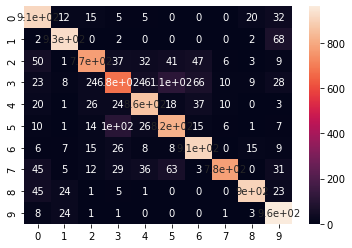

In [99]:
# initialize test dict
test_dict = dict()
for i in range(len(testset.classes)):
    test_dict[i] = dict()
    for cls in testset.classes:
        test_dict[i][cls] = 0

# initialize map
class_map = dict()
for i, cls in enumerate(testset.classes):
    class_map[i] = cls

# prepare model
print('##### Prepare Model #####')
model = models.vgg16(NUM_CLASS, False).to(device)
# load checkpoint
model.load_state_dict(torch.load('vgg_net.pth'))

# compute accuracy
print('##### Compute Metrics on Test Data #####')
test_acc = 0.0
test_auc = 0.0
test_confusion_mat = 0.0
test_nmi = 0.0
test_ari = 0.0
test_prec = 0.0
test_recall = 0.0
test_f1 = 0.0
model.eval()
for (imgs, target) in tqdm(testloader):
    imgs, target = imgs.cuda(), target.cuda()
    with torch.no_grad():
        pred = model(imgs)
        prob = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1)

        target_np, prob_np, pred_np = target.data.cpu().numpy(), prob.data.cpu().numpy(), pred.data.cpu().numpy()

        # update test dict
        for i in range(target_np.shape[0]):
            cls = class_map[target_np[i]]
            test_dict[pred_np[i]][cls] += 1

        # update metrics
        acc = accuracy_score(target_np, pred_np)
        confusion_mat = confusion_matrix(target_np, pred_np, labels=np.arange(0, len(testloader.dataset.classes)))
        nmi = normalized_mutual_info_score(target_np, pred_np)
        ari = adjusted_rand_score(target_np, pred_np)
        prec = precision_score(target_np, pred_np, average='macro')
        recall = recall_score(target_np, pred_np, average='macro')
        f1 = f1_score(target_np, pred_np, average='macro')
    test_acc += acc
    test_confusion_mat += confusion_mat
    test_nmi += nmi
    test_ari += ari
    test_prec += prec
    test_recall += recall
    test_f1 += f1

test_acc /= len(testloader)
test_nmi /= len(testloader)
test_ari /= len(testloader)
test_prec /= len(testloader)
test_recall /= len(testloader)
test_f1 /= len(testloader)


print(f'Accuracy on test data: {test_acc:.4f}')
print(f'Precision on test data: {test_prec:.4f}')
print(f'Recall on test data: {test_recall:.4f}')
print(f'F1-score on test data: {test_f1:.4f}')
print(f'NMI score on test data: {test_nmi:.4f}')
print(f'ARI score on test data: {test_ari:.4f}')
print('Confusion matrix on test data')
print(f'{testset.classes}')
print(test_confusion_mat)

# plot heatmap
sns_plot = sns.heatmap(test_confusion_mat, annot=True)
sns_plot.figure.savefig('heatmap_vgg.png')